In [21]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time as time
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import IntSlider, FloatSlider, Dropdown, Checkbox, FloatLogSlider

import torch



from mpol import (
    coordinates,
    crossval,
    datasets,
    gridding,
    images,
    fourier,
    losses,
    precomposed,
)

from training_func import train, seed_from_dirty_image

## Observed data

Todos:

<input type="checkbox">  Explain what array configuration, dirty beam, and dirty image are and show plots

### Preparation of observed visibilities

<input type="checkbox">  Explain the the steps that led to the .npz file

In [11]:
fname = '../data/visibilities/RDor_spw0.split.fixvis.averaged_kilolambda_flags_removed_weights_rescaled.npz' # path to the .npz file containing the observed visibilities
cell_size = 0.001 # arcseconds
npix = 128 # number of pixels per image axis

- **mpol.coordinates.gridcoords** object:\
Two numbers, cell_size and npix, uniquely define a grid in image space and in Fourier space.\
The mpol.coordinates.GridCoords object is mainly a container for all of the information about this grid.\
It uses desired image dimensions (via the cell_size and npix arguments) to define a corresponding Fourier plane grid.\
**coords.img_ext** gives the *extent* parameter for plt.imshow() to plot the image.

- **mpol.gridding.DataAverager()** object:
Grids the loose visibilities to the Fourier grid defined by GridCoords, as done by the **DirtyImager** object.\
Then, it can use the **mpol.gridding.DataAverager.to_pytorch_dataset()** routine to convert the gridded visibilities to a PyTorch dataset.\
This gridded visibility dataset in  pytorch format can later be used to calculate likelihoods and in the imaging loop.

In [20]:
# load the visibilities from the .npz file
d = np.load(fname)
uu = d["uu"]
vv = d["vv"]
weight = d["weight"]
data = d["data"]
data_re = np.real(data)
data_im = np.imag(data)
nvis = len(uu)
# print(f'Loaded visibilities from {fname}.')
print(f'The dataset has {nvis} visibilities.\n')

# create the gridder
coords = coordinates.GridCoords(cell_size=cell_size, npix=npix)
averager = gridding.DataAverager(
    coords=coords, uu=uu, vv=vv, weight=weight, data_re=data_re, data_im=data_im
)
# export to PyTorch dataset
dset = averager.to_pytorch_dataset()

The dataset has 409558 visibilities.



### Plot Baselines

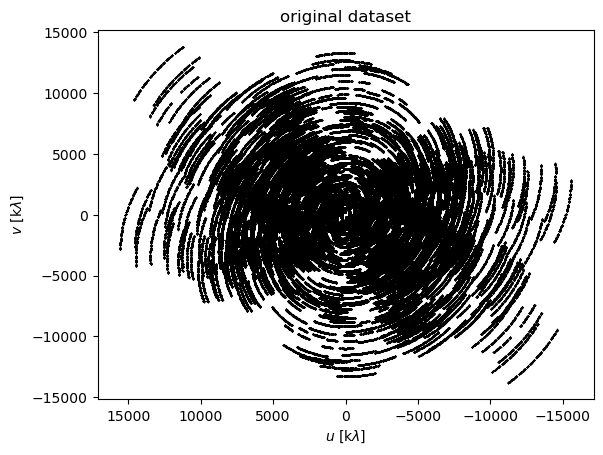

In [22]:
fig, ax = plt.subplots(nrows=1)
ax.scatter(uu, vv, s=1.5, rasterized=True, linewidths=0.0, c="k")
ax.scatter(
    -uu, -vv, s=1.5, rasterized=True, linewidths=0.0, c="k"
)  # and Hermitian conjugates
ax.set_xlabel(r"$u$ [k$\lambda$]")
ax.set_ylabel(r"$v$ [k$\lambda$]")
ax.set_title("original dataset")
ax.invert_xaxis()

### Plots of visibility vs uv distance

<input type="checkbox">  Ask Wouter what the significance of the plots are.

<input type="checkbox">  Ask Wouter: why the phase plot looks like that?

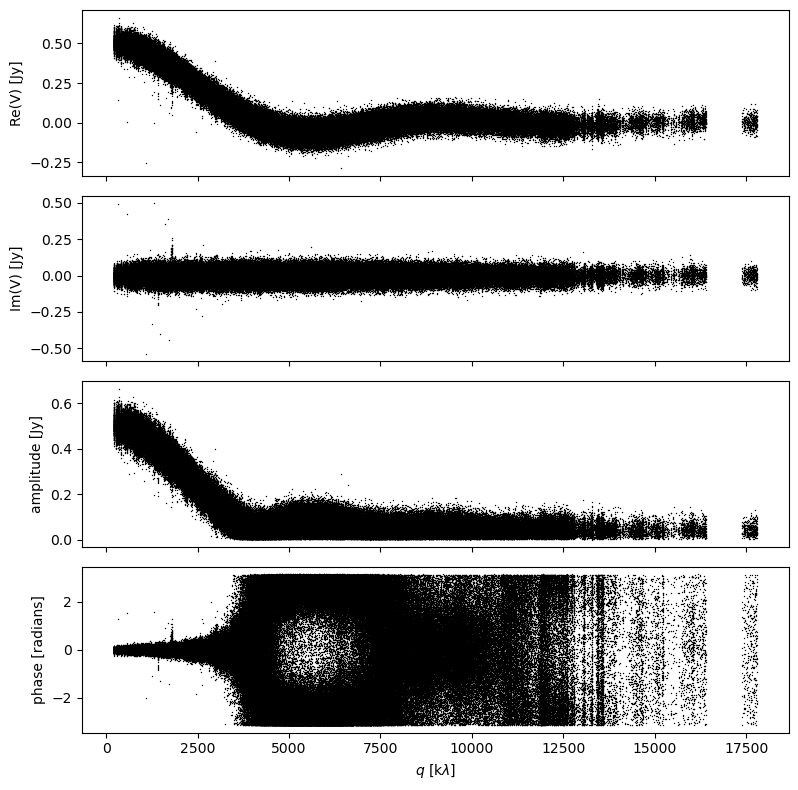

In [23]:
#calculate the amplitude and phase of the visibilities
amp = np.abs(data)
phase = np.angle(data)

# calculate the uv distance (baseline separations in meters, calculated as sqrt(u*u+v*v))
uvdist = np.hypot(uu, vv)

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(8, 8))
pkw = {"s":1, "rasterized":True, "linewidths":0.0, "c":"k"}

ax[0].scatter(uvdist, data.real, **pkw)
ax[0].set_ylabel("Re(V) [Jy]")

ax[1].scatter(uvdist, data.imag, **pkw)
ax[1].set_ylabel("Im(V) [Jy]")

ax[2].scatter(uvdist, amp, **pkw)
ax[2].set_ylabel("amplitude [Jy]")

ax[3].scatter(uvdist, phase, **pkw)
ax[3].set_ylabel("phase [radians]")
ax[3].set_xlabel(r"$q$ [k$\lambda$]")

plt.tight_layout()
plt.show()

### Show the dirty beam

- **mpol.gridding.DirtyImager** object:\
Instantiating the DirtyImager object attaches the GridCoords object and the loose visibilities.\
The mpol.gridding.DirtyImager.get_dirty_image() routine will average, or ‘grid’, the loose visibilities to the Fourier grid defined by GridCoords.\
It will then calculate the diagnostic dirty image and dirty beam cubes that correspond to the Fourier transform of the gridded visibilities, using the **mpol.gridding.DirtyImager.get_dirty_image()** routine\
Weighting and tapering can be applied to the visibilities in this routine.

Text(0, 0.5, '$\\Delta \\delta$ [${}^{\\prime\\prime}$]')

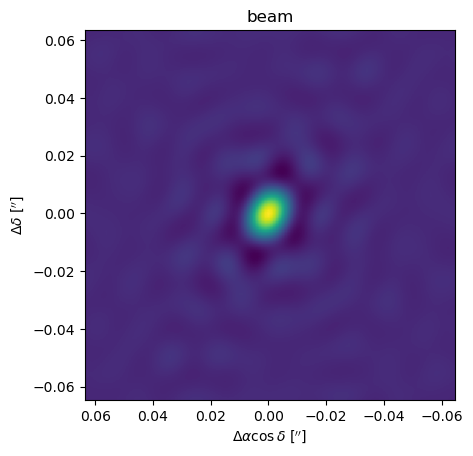

In [18]:
img, beam = imager.get_dirty_image(weighting="briggs", robust=0.0)
kw = {"origin": "lower", "extent": imager.coords.img_ext}
fig, ax = plt.subplots(ncols=1)
ax.imshow(np.squeeze(beam), **kw)
ax.set_title("beam")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ [${}^{\prime\prime}$]")
ax.set_ylabel(r"$\Delta \delta$ [${}^{\prime\prime}$]")

### Make a dirty image using the built-in function
- A simple fourier inversion
- Plot

Text(0, 0.5, '$\\Delta \\delta$ [${}^{\\prime\\prime}$]')

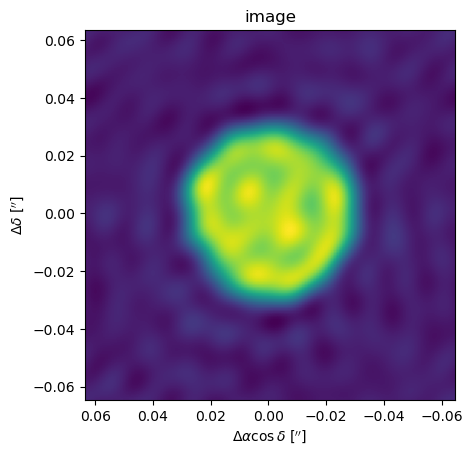

In [15]:
imager = gridding.DirtyImager(
    coords=coords, uu=uu, vv=vv, weight=weight, data_re=data_re, data_im=data_im
)

# Show the dirty image
img, beam = imager.get_dirty_image(weighting="uniform", robust=0.0, max_scatter=1.5)
kw = {"origin": "lower", "extent": imager.coords.img_ext}
fig, ax = plt.subplots(ncols=1)
ax.imshow(np.squeeze(img), **kw)
ax.set_title("image")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ [${}^{\prime\prime}$]")
ax.set_ylabel(r"$\Delta \delta$ [${}^{\prime\prime}$]")